In [1]:
import numpy as np
from numpy import Inf
import matplotlib.pyplot as plt
import sys
import pyEXP
##  exp
sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
#import simpleSL

## Auriga
import LibAu as la

In [2]:
nhalo=21 #Name Halo
nsnap= 63 #z=0
sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap) #Read Simulation
header = sim.Header()
h=header['hubbleparam']
sc=header['time']

Rvir =sim.sf.data['frc2'][0]*1000*sc/h
Mvir =sim.sf.data['fmc2'][0]*1e10/h
Npart = sim.sf.data['slty'][0]
print(Mvir,Rvir,Npart)

fields_stars = ['pos','vel','id','mass','type','pot','age']
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)


fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
#Rotate Halo
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

Datstars=Data['stars']
DatDM = Data['dm1']

potdm = DatDM['pot']
pos = DatDM['pos'] #part_rot[not_in_subs]
mass = DatDM['mass']  #part['dark']['mass'][not_in_subs]

poss,masss=Datstars['pos'],Datstars['mass']

2088654433553.4023 349.25210558595916 [11792260 31503466        0        0 19107866        1]


/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


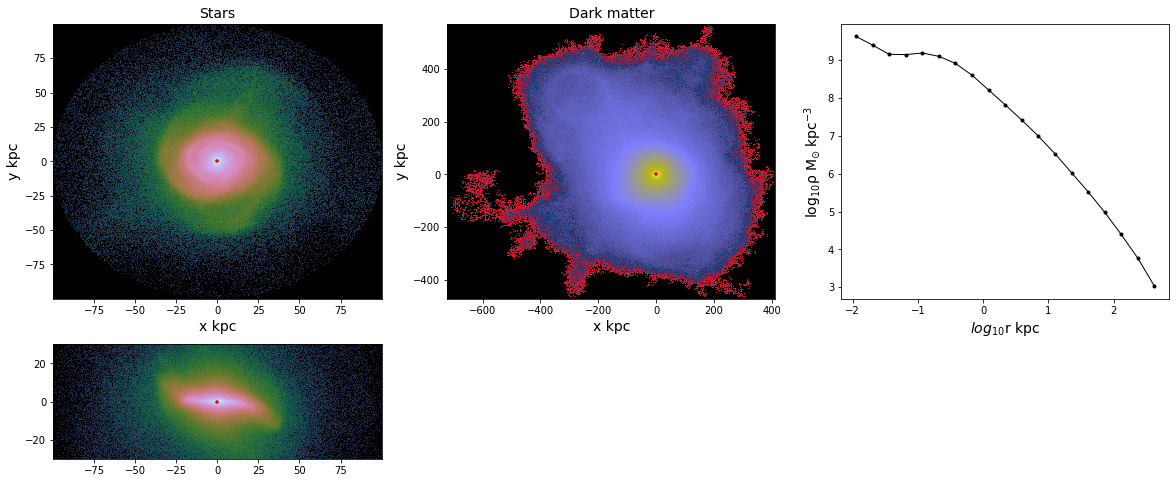

In [3]:
rstar2d = np.sqrt(poss[:,0]**2 + poss[:,1]**2)
cuts = (rstar2d<=100)&(np.abs(poss[:,2])<=30)
Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(poss[:,0][cuts],poss[:,1][cuts],masss[cuts],npix = [720,720],style='SD')
Hse,_xse,_yse,boxse = la.StellarDensity2D(poss[:,0][cuts],poss[:,2][cuts],masss[cuts],npix = [720,int(720/2)],style='SD')

Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(pos[:,0],pos[:,1],mass,npix = [720,720],style='SD')
    

plt.figure(figsize=(20,8))
    
ax1=plt.subplot(3,3,(1,4))
ax1.patch.set_facecolor('black')
extentsf = _xsf.min(),_xsf.max(),_ysf.min(),_ysf.max()
plt.imshow(np.log10(Hsf).T,cmap='cubehelix',extent=extentsf,aspect='auto',origin='lower',interpolation='none')
plt.scatter(0,0,s=20,c='r',marker='+')
#plt.title('Au-%s'%nhalo,fontsize=14)
plt.title('Stars',fontsize=14)
plt.xlabel('x kpc',fontsize=14)
plt.ylabel('y kpc',fontsize=14)
    
ax2=plt.subplot(3,3,7)
ax2.patch.set_facecolor('black')
extentse = _xse.min(),_xse.max(),_yse.min(),_yse.max()
plt.imshow(np.log10(Hse).T,cmap='cubehelix',extent=extentse,aspect='auto',origin='lower',interpolation='none')
plt.scatter(0,0,s=20,c='r',marker='+')

ax3=plt.subplot(3,3,(2,5))
ax3.patch.set_facecolor('black')
extentdm = _xdm.min(),_xdm.max(),_ydm.min(),_ydm.max()
plt.imshow(np.log10(Hdm).T,cmap='gist_stern',extent=extentdm,aspect='auto',origin='lower',interpolation='none')
plt.scatter(0,0,s=10,c='r',marker='+')
plt.title('Dark matter',fontsize=14)
plt.xlabel('x kpc',fontsize=14)
plt.ylabel('y kpc',fontsize=14)
    
plt.subplot(3,3,(3,6))
r3dm = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
r3dml = np.log10(r3dm)
DR = np.linspace(r3min,r3max,20)
DRn = 10**DR
rho_ = []
for i,j in enumerate(DR):
    if i==len(DR)-1:continue
    sel = (DR[0]<=r3dml)&(r3dml<DR[i+1])
    vol = (4./3.)*np.pi*(DRn[i+1]**3 - DRn[0]**3)
    rho_.append(np.sum(mass[sel])/vol)

plt.plot(DR[:-1],np.log10(rho_),lw=1,marker='.',c='k')
plt.ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
plt.xlabel(r'$log_{10}$r kpc',fontsize=14)
#print(DR,rho)
    
plt.subplots_adjust(hspace=0.4)
#plt.savefig('plots/profiles_Au%s.pdf'%nhalo)
plt.show()
plt.close()

In [4]:
print('IDhalo: Au-%s'%nhalo)
print('Nsnap: %s'%nsnap)
print('R200: %.3f kpc'%Rvir)
print('M200: %.3f Msun'%np.log10(Mvir))
print('Ngas: %e '%Npart[0])
print('Ndm: %e '%Npart[1])
print('Nstar: %e '%Npart[4])
print('Ntot: %e '%(np.sum(Npart)-1))


IDhalo: Au-21
Nsnap: 63
R200: 349.252 kpc
M200: 12.320 Msun
Ngas: 1.179226e+07 
Ndm: 3.150347e+07 
Nstar: 1.910787e+07 
Ntot: 6.240359e+07 


In [5]:

print(np.sum(mass), mass[0], len(pos), len(mass))
M_tot = np.sum(mass)

#selecting 1million random particles
#ind = np.arange(0,len(mass),1,dtype=int)
#sel = np.random.choice(ind, 1000000, replace=False).astype(int)
#pos,mass = pos[sel],mass[sel]
#potdm=potdm[sel]
 
Mfac = M_tot/np.sum(mass)
#mass = mass*Mfac

rr = np.sqrt((pos[:,0]**2) + (pos[:,1]**2) + (pos[:,2]**2))
#cutr2=rr<=Rvir
#pos,mass,rr = pos[cutr2],mass[cutr2],rr[cutr2]
#potdm=potdm[cutr2]

rrmin,rrmax=np.nanmin(np.log10(rr)),np.nanmax(np.log10(rr))
r,rho = return_density(np.log10(rr),weights= 1., rangevals=[rrmin, rrmax],bins=200)
print(rrmin,rrmax,Rvir)



1909857200000.0 60622.2 31503466 31503466
-1.9485474 2.8768125 349.25210558595916


In [6]:
#r, rho = halo_st.density_profile(nbins=100, rmin=0, rmax=600)
R,D,M,P = makemodel_empirical(r, rho, "Au{}_table.txt".format(nhalo))

! Scaling:  R= 732.4012190339452   M= 1.0
1.0 3.17638124308256e-08 3.17638124308256e-08 3.17638124308256e-08


Text(0.5, 0, 'R')

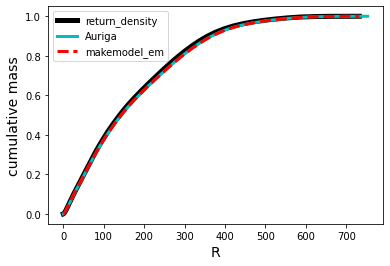

In [7]:
#pos,mass
#Ordeno datos de Auriga
rbord = np.argsort(rr)
rb,mb,pwau = rr[rbord],mass[rbord],potdm[rbord]
#ran = (rb<=r[-1])
#rb,mb,pwau = rb[ran],mb[ran],pwau[ran] #Datos directamente de Auriga
mbacc = np.arange(len(rb)) / float(len(rb))#np.cumsum(mb)
#########################################################
#datos de return_density
dm = (4/3)*np.pi*D*(R**3)
#dm2 = 2*np.pi*(rbins**2)*dreturn*(rbins[1]-rbins[0])
Macc = np.cumsum(dm)
 

rmax = np.nanmax(r)
plt.subplot(111)
plt.plot(r,Macc/Macc[-1],color='k',label='return_density',lw=5)
plt.plot(rb,mbacc/mbacc[-1],color='c',label='Auriga',lw=3,ls='-')
plt.plot(R, M,c='r',ls='--', label='makemodel_em',lw=3)
plt.legend()
plt.ylabel('cumulative mass',fontsize=14)
plt.xlabel('R',fontsize=14)

4.5433154170959243e-39


Text(0.5, 0, 'R')

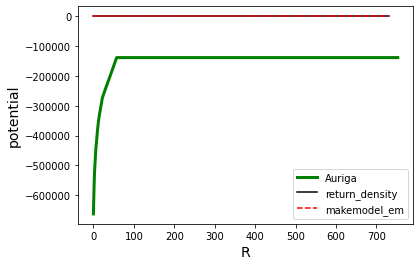

In [30]:
G= 6.674*1e-11 #m3⋅kg−1⋅s−2
m2kpc, kg2Msun = 3.2408*1e-20,5e-31
G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
print(G)
#pvals = -mvals/(rvals+1.e-10) - (pwvals[dvals.size-1] - pwvals)

pwau_ = pwau*(3.24078e-17)**2 /G# (1/(G*mbacc[-1]) )
pwauacc = ((-mbacc/rb) - (np.sum(pwau_)-np.cumsum(pwau_)))#  *(rb[-1]/mbacc[-1])
Potau = ((-mbacc/rb) - (np.sum(1/rb)-np.cumsum(1/rb))) #*(1/mbacc[-1]) # <----------

Pw = dm/r
Pwacc = ((-Macc/r) - (np.sum(Pw)-np.cumsum(Pw)))  *(1/Macc[-1])
plt.subplot(111)

plt.plot(rb,Potau,color='g',label='Auriga',lw=3)
plt.plot(r,Pwacc,color='k',label='return_density')
plt.plot(R, P,c='r',ls='--', label='makemodel_em')
plt.legend()
plt.ylabel('potential',fontsize=14)
plt.xlabel('R',fontsize=14)

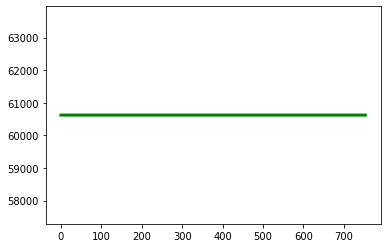

In [23]:
plt.plot(rb,mb,color='g',label='Auriga',lw=3)

In [9]:
config="""
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 5
  nmax: 10
  modelname: %s_table.txt
...
"""%(len(R),np.min(R), np.max(R),'Au'+str(nhalo))
print(config)


---
id: sphereSL
parameters :
  numr: 200
  rmin: 0.011574867713644146
  rmax: 732.4012190339452
  Lmax: 5
  nmax: 10
  modelname: Au21_table.txt
...



In [10]:
basis = pyEXP.basis.Basis.factory(config)


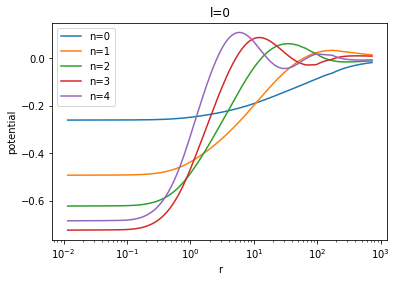

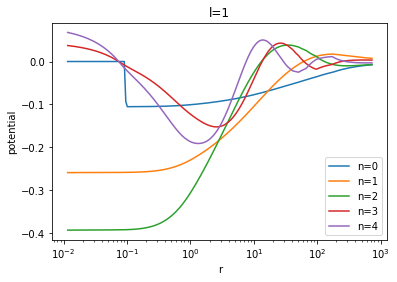

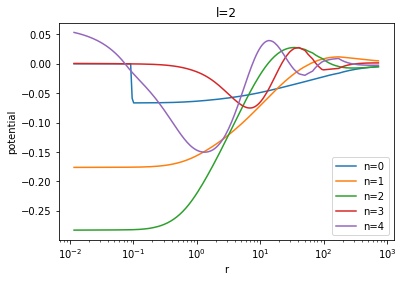

In [11]:

# Construct the basis instances
#
#basis = pyEXP.basis.Basis.factory(config)

# Prints info from Cache
#basis.cacheInfo('.slgrid_sph_cache')


lrmin = np.log10(np.min(R))
lrmax = np.log10(np.max(R))
rnum  = len(R) 
basis_grid = basis.getBasis(lrmin, lrmax, rnum)


r = np.linspace(lrmin, lrmax, rnum)
r = np.power(10.0, r)


for l in range(3):
    for n in range(5):
        plt.semilogx(r, basis_grid[l][n], '-', label="n={}".format(n))
    plt.xlabel('r')
    plt.ylabel('potential')
    plt.title('l={}'.format(l))
    plt.legend()
    #plt.savefig('/mnt/home/nico/projects/cosmo_wakes/pyEXP_ex/m12i_test_empirical_basis_{}.png'.format(l), bbox_inches='tight
    plt.show()


In [12]:
coef = basis.createFromArray(mass=mass, pos=pos, time=0.0)
#
print("Time=", coef.time, " geometry=", coef.geometry)
print("Shape=", coef.data.shape)
#print("Data=\n", coef.data)

Time= 0.0  geometry= sphere
Shape= (21, 10)


In [13]:
times = coef.time
data  = coef.data

In [14]:
data.shape,times

((21, 10), 0.0)

In [15]:
data[0,:]

array([ 5.35542729e+11+0.j,  1.07452470e+10+0.j, -6.66556931e+09+0.j,
        2.68334858e+09+0.j,  6.89676512e+08+0.j, -3.99770219e+09+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j])

basis.createFromArray?

basis.getFields?

In [16]:
pos.shape

(31503466, 3)

In [17]:
Dmon,Dnmon,Pmon,Pnmon=[],[],[],[]
for xi,yi,zi in pos:
    dens0,potl0,dens,potl,fx,fy,fz = basis.getFields(x=xi,y=yi,z=zi)
    Dmon.append(dens0)
    Dnmon.append(dens)
    Pmon.append(potl0)
    Pnmon.append(potl)

KeyboardInterrupt: 

---

---

---

---

In [ ]:
den0, den1,pot0,pot1 = np.array(Dmon),np.array(Dnmon),np.array(Pmon),np.array(Pnmon)

In [ ]:
Npx=30
Hden,Hpot,Hpotmed = np.zeros((Npx,Npx)),np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
den_mon,den_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
pot_mon,pot_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
xb,yb=np.linspace(pos[:,0].min(), pos[:,0].max(),Npx),np.linspace(pos[:,1].min(), pos[:,1].max(),Npx)
dx,dy= xb[1]-xb[0],yb[1]-yb[0]
xgrid, ygrid = np.meshgrid(xb, yb)

rbord = np.argsort(rr)
rb,mb = rr[rbord],mass[rbord]
rbord1=np.argsort(rbord)
mbacc = np.cumsum(mb)
Pot_au=  ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb)))[rbord1]

for j in range(yb.size -1):
    for i in range(xb.size-1):
        sel = (xb[i]<=pos[:,0])&(pos[:,0]<=xb[i+1]) & (yb[j]<=pos[:,1])&(pos[:,1]<=yb[j+1])
        if len(pos[:,2][sel])>0:
            dz = np.nanmax(pos[:,2][sel])-np.nanmin(pos[:,2][sel])
            Hden[j][i] = np.sum(mass[sel])/(dx*dy*dz)
            den_mon[j][i],den_nonmon[j][i]=np.median(den0[sel]),np.median(den1[sel])
            
            Hpot[j][i] = np.sum(Pot_au[sel])/(dx*dy*dz)#potdm
            Hpotmed[j][i] = np.median(Pot_au[sel])#potdm
            pot_mon[j][i],pot_nonmon[j][i]=np.median(pot0[sel]),np.median(pot1[sel])
        else: pass

In [ ]:
km2kpc=3.24078e-17

Hpot_= np.log10(np.abs( Hpotmed))#* (rbins[-1]/(G*Macc[-1]) )    ))

fig, ax = plt.subplots(1, 3, figsize=(25,6))
extent = xb.min(),xb.max(),yb.min(),yb.max()
im = ax[0].imshow(Hpot_,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im, ax=ax[0],label='Potential')
#im.set_clim(7,12)
ax[0].set_title('Input Data',fontsize=18)
#*(rbins[-1]/(Macc[-1]) ) 
#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
im2 = ax[1].imshow(np.log10(np.abs(pot_mon + pot_nonmon)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im2, ax=ax[1],label='Potential')
im2.set_clim(im.get_clim()[0],im.get_clim()[1])
ax[1].set_title('Potential Field Reconstruction',fontsize=18)


potresidual = (Hpotmed - (pot_mon + pot_nonmon))/Hpotmed

#im3 = ax[2].imshow(denmask,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
im3 = ax[2].contourf(xgrid, ygrid, potresidual,50,cmap='gist_stern')
plt.colorbar(im3, ax=ax[2],label='Potential')
#im3.set_clim(7,12)
for i_ in [0,1,2]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
ax[2].set_title('Residual',fontsize=18)
plt.show()
plt.close()